In [2]:
!pip install pandas
!pip install torch
!pip install torchvision
!pip install qiskit
!pip install sklearn

  Using cached pandas-1.4.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached torch-1.11.0-cp39-cp39-manylinux1_x86_64.whl (750.6 MB)
  Using cached torchvision-0.12.0-cp39-cp39-manylinux1_x86_64.whl (21.0 MB)
  Using cached qiskit-0.35.0-py3-none-any.whl
  Using cached qiskit_ibmq_provider-0.18.3-py3-none-any.whl (238 kB)
  Using cached qiskit_ignis-0.7.0-py3-none-any.whl (200 kB)
  Using cached qiskit_aer-0.10.3-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (18.0 MB)
  Using cached qiskit_terra-0.20.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached requests_ntlm-1.1.0-py2.py3-none-any.whl (5.7 kB)
  Using cached retworkx-0.11.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached ply-3.11-py2.py3-none-any.whl (49 kB)
  Using cached stevedore-3.5.0-py3-none-any.whl (49 kB)
  Using cached sympy-1.10.1-py3-none-any.whl (6.4 MB)
  Using cached twe

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [7]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])
    
simulator = qiskit.Aer.get_backend('qasm_simulator')
circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.49


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [8]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [9]:
children = pd.read_csv('encoded.csv')
children = children.drop(axis=1, columns=['Unnamed: 0'])
children.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,1,1,0,0,1,1,0,1,0,0,0,0,0,0
1,1,1,0,0,1,1,0,1,0,0,0,0,0,0
2,1,1,0,0,0,1,1,1,0,0,0,0,0,0
3,0,1,0,0,1,1,0,0,0,1,1,1,0,0
4,1,1,1,1,1,1,1,1,1,1,0,1,1,0


In [10]:
adolescent = pd.read_csv('EncodedAdolescent.csv')
adolescent = adolescent.drop(axis=1, columns=['id'])
adolescent.rename(columns={"austim": "autism"}, inplace=True)
adolescent.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,0,0,0,1,1,1,1,1,1,0,0,1,0,1
1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,1,0,0,0
3,0,1,1,1,1,1,0,1,1,0,1,0,1,0
4,1,1,1,1,1,1,1,0,0,0,1,0,1,0


In [11]:
data = pd.concat([children, adolescent])
data.reset_index(inplace=True)
data = data.drop(axis=1, columns=['index'])
print(data.shape)
data.tail()

(396, 14)


,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
391,0,1,1,1,0,1,1,0,1,0,1,0,0,0
392,1,0,1,0,0,0,0,1,0,1,0,0,0,0
393,1,0,0,1,1,1,1,1,1,1,1,0,1,0
394,1,1,0,1,1,0,0,0,1,1,1,0,0,0
395,1,0,1,0,0,1,1,1,1,0,0,0,0,0


In [12]:
sample = data[data.autism == 0].sample(frac=1/5, random_state=10)
data2 = pd.concat([sample, data[data.autism ==1]])
data2.reset_index(inplace=True)
data2 = data2.drop(axis=1, columns=['index'])
data2

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
1,1,1,0,0,0,0,1,0,1,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,0,1,0
3,1,1,1,1,1,1,1,1,0,0,1,0,1,0
4,0,1,1,1,1,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1,1,0,0,0,1,0,1,1,1,1,0,0,1
126,1,1,1,1,0,1,0,0,1,1,1,0,1,1
127,1,1,1,0,1,0,1,0,1,0,0,0,0,1
128,1,1,0,1,1,1,1,1,1,1,0,1,1,1


In [13]:
adults = pd.read_csv('adult_encoded.csv')
adults.drop(axis=1, columns=['Unnamed: 0'], inplace=True)
print(adults.shape)
adults.head()

(609, 95)


,age,result,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,...,contry_of_res_United Kingdom,contry_of_res_United States,contry_of_res_Uruguay,contry_of_res_Viet Nam,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,Class/ASD
0,0.024590,0.6,1,1,1,1,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
1,0.019126,0.5,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.027322,0.8,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
3,0.049180,0.6,1,1,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
4,0.051913,0.9,1,1,1,1,1,0,1,1,...,0,1,0,0,0,0,0,0,1,1


In [14]:
adults2 = pd.read_csv('adult_encoded2.csv')
adults2.drop(axis=1, columns=['Unnamed: 0'], inplace=True)
print(adults2.shape)
adults2.head()

(609, 93)


,age,result,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,...,contry_of_res_United Kingdom,contry_of_res_United States,contry_of_res_Uruguay,contry_of_res_Viet Nam,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,Class/ASD
0,26.0,6,1,1,1,1,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
1,24.0,5,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,27.0,8,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
3,35.0,6,1,1,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
4,36.0,9,1,1,1,1,1,0,1,1,...,0,1,0,0,0,0,0,0,1,1


In [15]:
adults2['Class/ASD'].value_counts()

0    429
1    180
Name: Class/ASD, dtype: int64

In [16]:
len(adults2.columns)

93

In [17]:
all_ages = pd.read_csv('all_ages.csv')
all_ages.drop(axis=1, columns=['Unnamed: 0'], inplace=True)
print(all_ages.shape)
all_ages.head()

(955, 117)


,age,result,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,...,contry_of_res_Iraq,contry_of_res_Isle of Man,contry_of_res_Japan,contry_of_res_Libya,contry_of_res_Malta,contry_of_res_Nigeria,contry_of_res_South Korea,contry_of_res_Syria,contry_of_res_U.S. Outlying Islands,relation_self
0,26.0,6,1,1,1,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,5,1,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27.0,8,1,1,0,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.0,6,1,1,0,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36.0,9,1,1,1,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print(len(all_ages.columns))
all_ages['Class/ASD'].value_counts()

117


0    587
1    368
Name: Class/ASD, dtype: int64

In [19]:
# def partition(data, n):
#     """Randomly partitions the data into n non-overlapping parts
#     Args:
#         data: dataframe object, the dataset to partition
#         n: number of equal parts to split the data
#     Returns:
#         splits: list of n parts of the data, each one is a dataframe
#     """
#     splits = []
#     remaining = data.copy(deep=True)
#     for i in range(n):
#         split = remaining.sample(frac=1/(n-i), random_state=10)
#         splits.append(split)
#         remaining = remaining.drop(split.index)
#     return splits

# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [20]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(116, 116)
        self.fc2 = nn.Linear(116, 1)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        # self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        # x = F.relu(self.conv1(x))
        # x = F.max_pool2d(x, 2)
        # x = F.relu(self.conv2(x))
        # x = F.max_pool2d(x, 2)
        # x = self.dropout(x)
        # x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        x = self.hybrid1(x)
        # x = self.hybrid2(x)
        return torch.cat((x, 1 - x), -1)

Net(
  (fc1): Linear(in_features=116, out_features=116, bias=True)
  (fc2): Linear(in_features=116, out_features=1, bias=True)
  (hybrid1): Hybrid()
)

In [37]:
def train_model(model, optimizer, epochs, train_loader, test_loader):
    train_loss_list = []
    
    for epoch in range(epochs):
        losses = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # Forward pass
            output = model(data)
            outputs_train.append(output)
            # Calculate loss
            loss = loss_func(output, target)
            # Backward pass
            loss.backward()
            # Optimize weights
            optimizer.step()
            losses.append(loss.item())
        train_loss_list.append(sum(losses)/len(losses))
        print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, train_loss_list[-1]))
        
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        losses = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            outputs_test.append(output)
            pred = output.argmax(dim=1, keepdim=True)
            preds_test.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            losses.append(loss.item())

        print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
            sum(losses) / len(losses),
            correct / len(test_loader) * 100)
            )
        test_loss = sum(losses) / len(losses)
        accuracy = correct / len(test_loader) * 100
    return train_loss_list, test_loss, accuracy

In [24]:
from sklearn.model_selection import train_test_split

In [34]:
X = all_ages.drop(axis=1, columns=['Class/ASD'])
y = all_ages['Class/ASD']
# y = data2.autism.astype('int64')
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=10)
# X_train, X_test, Y_train, Y_test = X, X, y, y

In [38]:
training_times = []
all_accuracy = []
all_train_loss = []
all_test_loss = []

outputs_train = []
outputs_test = []
preds_test = []

X_train_series_list = []
for _, row in X_train.iterrows():
    tensor_from_series = df_to_tensor(row)
    X_train_series_list.append(tensor_from_series)
X_train_tensor = torch.stack(X_train_series_list)

Y_train_tensor = df_to_tensor(Y_train)
Y_train_tensor = Y_train_tensor.type(torch.int64)

train_data = CustomDataset(data=X_train_tensor, targets=Y_train_tensor)

X_test_series_list = []
for _, row in X_test.iterrows():
    tensor_from_series = df_to_tensor(row)
    X_test_series_list.append(tensor_from_series)
X_test_tensor = torch.stack(X_test_series_list)

Y_test_tensor = df_to_tensor(Y_test)
Y_test_tensor = Y_test_tensor.type(torch.int64)

test_data = CustomDataset(data=X_test_tensor, targets=Y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [39]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
epochs = 20
model.train()

print(f"Train: {len(X_train)} samples, test: {len(X_test)} samples")
t = time()
train_loss_list, test_loss, accuracy = train_model(model, optimizer, epochs, train_loader, test_loader)
training_times.append(time() - t)
print("Training time: %.2fs" % (time() - t))
all_accuracy.append(accuracy)
all_train_loss.append(train_loss_list)
all_test_loss.append(test_loss)

Train: 668 samples, test: 287 samples


/tmp/ipykernel_114/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.7433
Training [10%]	Loss: -0.8460
Training [15%]	Loss: -0.8830
Training [20%]	Loss: -0.8869
Training [25%]	Loss: -0.8943
Training [30%]	Loss: -0.9075
Training [35%]	Loss: -0.9099
Training [40%]	Loss: -0.9064
Training [45%]	Loss: -0.9105
Training [50%]	Loss: -0.9181
Training [55%]	Loss: -0.9235
Training [60%]	Loss: -0.9262
Training [65%]	Loss: -0.9247
Training [70%]	Loss: -0.9259
Training [75%]	Loss: -0.9344
Training [80%]	Loss: -0.9298
Training [85%]	Loss: -0.9318
Training [90%]	Loss: -0.9321
Training [95%]	Loss: -0.9366
Training [100%]	Loss: -0.9429
Performance on test data:
	Loss: -0.8905
	Accuracy: 93.0%
Training time: 149.50s


In [28]:
i = 5
outputs_test[i], preds_test[i]

(tensor([[1., 0.]], dtype=torch.float64), tensor([[0]]))

In [29]:
int(outputs_test[i][0][0])

1

In [30]:
len(outputs_test), len(preds_test)

(955, 955)

In [33]:
Y_test.value_counts()

0    587
1    368
Name: Class/ASD, dtype: int64

In [31]:
preds_int = [int(pred) for pred in preds_test]
sum(preds_int)

382

In [37]:
test_data.targets

tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [81]:
train_data.targets[8], train_data.data[8]

(tensor(1),
 tensor([4., 9., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [84]:
train_data.targets[10], train_data.data[10]

(tensor(1),
 tensor([20.,  9.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]))

In [69]:
torch.save(model.state_dict(), 'model')

In [263]:
# Avg accuracy
# Old: 83.78954423449514
# Old: 82.68787456241874
# New: 84.82051282051282
# 87.39495798319328
sum(all_accuracy) / len(all_accuracy)

95.81881533101046

In [264]:
# Avg test loss
sum(all_test_loss) / len(all_test_loss)

-0.9014285714285718

In [40]:
# Avg training time
sum(training_times) / len(training_times)

164.1439561843872

Text(0, 0.5, '%')

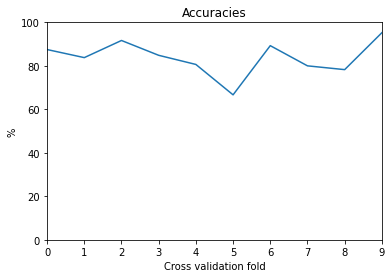

In [23]:
ax = plt.gca()
ax.set_xlim([0, 9])
ax.set_ylim([0, 100])

plt.plot(all_accuracy)
plt.title('Accuracies')
plt.xlabel('Cross validation fold')
plt.ylabel('%')

In [41]:
res = {
    "age": "21",
    "country": "American Samoa",
    "ethnicity": "Others",
    "gender": "1",
    "jaundice": "0",
    "q1": "0",
    "q10": "0",
    "q2": "0",
    "q3": "1",
    "q4": "0",
    "q5": "1",
    "q6": "0",
    "q7": "0",
    "q8": "0",
    "q9": "0",
    "relation": "Parent"
}

columns = ['age', 'result', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender_f', 'gender_m', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic', 'ethnicity_Latino', 'ethnicity_Middle Eastern ', 'ethnicity_Others', 'ethnicity_Pasifika', 'ethnicity_South Asian', 'ethnicity_Turkish', 'ethnicity_White-European', 'ethnicity_others', 'jundice_no', 'jundice_yes', 'contry_of_res_Afghanistan', 'contry_of_res_AmericanSamoa', 'contry_of_res_Angola', 'contry_of_res_Armenia', 'contry_of_res_Aruba', 'contry_of_res_Australia', 'contry_of_res_Austria', 'contry_of_res_Bahamas', 'contry_of_res_Bangladesh', 'contry_of_res_Belgium', 'contry_of_res_Bolivia', 'contry_of_res_Brazil', 'contry_of_res_Burundi', 'contry_of_res_Canada', 'contry_of_res_Chile', 'contry_of_res_China', 'contry_of_res_Costa Rica', 'contry_of_res_Cyprus', 'contry_of_res_Czech Republic', 'contry_of_res_Ecuador', 'contry_of_res_Egypt', 'contry_of_res_Ethiopia', 'contry_of_res_Finland', 'contry_of_res_France', 'contry_of_res_Germany', 'contry_of_res_Iceland', 'contry_of_res_India', 'contry_of_res_Indonesia', 'contry_of_res_Iran', 'contry_of_res_Ireland', 'contry_of_res_Italy', 'contry_of_res_Jordan', 'contry_of_res_Malaysia', 'contry_of_res_Mexico', 'contry_of_res_Nepal', 'contry_of_res_Netherlands', 'contry_of_res_New Zealand', 'contry_of_res_Nicaragua', 'contry_of_res_Niger', 'contry_of_res_Oman', 'contry_of_res_Pakistan', 'contry_of_res_Philippines', 'contry_of_res_Portugal', 'contry_of_res_Romania', 'contry_of_res_Russia', 'contry_of_res_Saudi Arabia', 'contry_of_res_Serbia', 'contry_of_res_Sierra Leone', 'contry_of_res_South Africa', 'contry_of_res_Spain', 'contry_of_res_Sri Lanka', 'contry_of_res_Sweden', 'contry_of_res_Tonga', 'contry_of_res_Turkey', 'contry_of_res_Ukraine', 'contry_of_res_United Arab Emirates', 'contry_of_res_United Kingdom', 'contry_of_res_United States', 'contry_of_res_Uruguay', 'contry_of_res_Viet Nam', 'relation_Health care professional', 'relation_Others', 'relation_Parent', 'relation_Relative', 'relation_Self', 'Class/ASD', 'contry_of_res_Albania', 'contry_of_res_Anguilla', 'contry_of_res_Argentina', 'contry_of_res_Azerbaijan', 'contry_of_res_Bahrain', 'contry_of_res_Comoros', 'contry_of_res_Croatia', 'contry_of_res_Greenland', 'contry_of_res_Norway', 'contry_of_res_Bhutan', 'contry_of_res_Bulgaria', 'contry_of_res_Europe', 'contry_of_res_Georgia', 'contry_of_res_Ghana', 'contry_of_res_Iraq', 'contry_of_res_Isle of Man', 'contry_of_res_Japan', 'contry_of_res_Libya', 'contry_of_res_Malta', 'contry_of_res_Nigeria', 'contry_of_res_South Korea', 'contry_of_res_Syria', 'contry_of_res_U.S. Outlying Islands', 'relation_self']

In [42]:
res_raw = dict()
for col in columns:
    if col == 'age':
        res_raw['age'] = int(res['age'])
    elif col.startswith('ethnicity_'):
        ethn = col[len("ethnicity_"):]
        if ethn == res['ethnicity']:
            res_raw['ethnicity_' + ethn] = 1
        else:
            res_raw['ethnicity_' + ethn] = 0
    elif col.endswith('_Score'):
        q_num = col[1:len(col)-len("_Score")]
        res_raw[col] = int(res["q" + q_num])
    elif col == 'result':
        res_raw['result'] = 0
    elif col.startswith("contry_of_res_"):
        if res['country'] == "American Samoa":
            res_raw['contry_of_res_AmericanSamoa'] = 1
        country = col[len("contry_of_res_"):]
        if country != "AmericanSamoa" and country == res['country']:
            res_raw['contry_of_res_' + country] = 1
        else:
            res_raw['contry_of_res_' + country] = 0
    elif col.startswith('relation_'):
        rela = col[len('relation_'):]
        if rela == res['relation']:
            res_raw["relation_" + rela] = 1
        else:
            res_raw["relation_" + rela] = 0
    elif col == "gender_f":
        if int(res['gender']) == 1:
            res_raw['gender_f'] = 1
        else:
            res_raw['gender_f'] = 0
    elif col == "gender_m":
        if int(res['gender']) == 0:
            res_raw['gender_m'] = 1
        else:
            res_raw['gender_m'] = 0
    elif col == "jundice_yes":
        if int(res['jaundice']) == 1:
            res_raw['jundice_yes'] = 1
        else:
            res_raw['jundice_yes'] = 0
    elif col == "jundice_no":
        if int(res['jaundice']) == 0:
            res_raw['jundice_no'] = 1
        else:
            res_raw['jundice_no'] = 0
    elif col != 'Class/ASD':
        res_raw[col] = 0
for i in range(1, 11):
    res_raw['result'] += res_raw[f'A{i}_Score']

In [43]:
len(res_raw) == len(columns), len(res_raw), len(columns)

(False, 116, 117)

In [44]:
vals_in_order = []
for col in columns:
    if col in res_raw:
        vals_in_order.append(res_raw[col])

In [45]:
new_data2 = {0: vals_in_order}
X_new = pd.DataFrame.from_dict(new_data2, orient='index', columns=[a for a in columns if a in list(res_raw.keys())])
X_new

,age,result,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,...,contry_of_res_Iraq,contry_of_res_Isle of Man,contry_of_res_Japan,contry_of_res_Libya,contry_of_res_Malta,contry_of_res_Nigeria,contry_of_res_South Korea,contry_of_res_Syria,contry_of_res_U.S. Outlying Islands,relation_self
0,21,2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
class NewData(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [77]:
X_series_list = []
for _, row in X_new.iterrows():
    tensor_from_series = df_to_tensor(row)
    X_series_list.append(tensor_from_series)
X_new_tensor = torch.stack(X_series_list)
new_data = NewData(data=X_new_tensor)
new_loader = torch.utils.data.DataLoader(
    new_data, batch_size=1, shuffle=True)
with torch.no_grad():
    for batch_idx, (data) in enumerate(new_loader):
        output = model(data)
        print(output[0][0], output[0][1])

tensor(0.9900, dtype=torch.float64) tensor(0.0100, dtype=torch.float64)


In [60]:
a = torch.tensor([4., 7., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.])
a

tensor([4., 7., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])